This fil will test out the plotting of time series and the derivation of indicators on financial data.
First, data needs to be fetched from Oanda - the broker of choice.

In [1]:
from interface import Interpretor

accounts =Interpretor.getAccounts()
accounts

{'accounts': [{'tags': [], 'id': '101-002-30846328-001'}]}

In [2]:
Interpretor.selectAccount(0)
Interpretor.getPrices('CAD_JPY', 'M15', '2022-01-01T00:00:00Z', 'CAD_JPY_M15_2022-01-01')

M15
Number of candles: 119497
Number of candles is too large, splitting into multiple requests
Number of requests: 23
Start DateTime: 2022-01-01T00:00:00Z
End DateTime: 2022-02-22T02:00:00Z
Number of candles returned: 3472
Start DateTime: 2022-02-22T02:00:00Z
End DateTime: 2022-04-15T04:00:00Z
Number of candles returned: 3660
Start DateTime: 2022-04-15T04:00:00Z
End DateTime: 2022-06-06T06:00:00Z
Number of candles returned: 3453
Start DateTime: 2022-06-06T06:00:00Z
End DateTime: 2022-07-28T08:00:00Z
Number of candles returned: 3656
Start DateTime: 2022-07-28T08:00:00Z
End DateTime: 2022-09-18T10:00:00Z
Number of candles returned: 3500
Start DateTime: 2022-09-18T10:00:00Z
End DateTime: 2022-11-09T12:00:00Z
Number of candles returned: 3608
Start DateTime: 2022-11-09T12:00:00Z
End DateTime: 2022-12-31T14:00:00Z
Number of candles returned: 3496
Start DateTime: 2022-12-31T14:00:00Z
End DateTime: 2023-02-21T16:00:00Z
Number of candles returned: 3524
Start DateTime: 2023-02-21T16:00:00Z
End D

In [3]:
import pandas as pd
import json

data_file = None
with open('CAD_JPY_M15_2022-01-01.json', 'r') as f:
    data = json.loads(f.read())

candles = data["candles"]

df = pd.DataFrame(candles)
df.head()

,complete,volume,time,bid,ask
0,True,13,2022-01-02T22:00:00.000000000Z,"{'o': '90.981', 'h': '90.983', 'l': '90.970', ...","{'o': '91.181', 'h': '91.183', 'l': '91.170', ..."
1,True,49,2022-01-02T22:15:00.000000000Z,"{'o': '91.000', 'h': '91.010', 'l': '90.963', ...","{'o': '91.200', 'h': '91.210', 'l': '91.163', ..."
2,True,18,2022-01-02T22:30:00.000000000Z,"{'o': '90.992', 'h': '91.002', 'l': '90.977', ...","{'o': '91.192', 'h': '91.202', 'l': '91.177', ..."
3,True,27,2022-01-02T22:45:00.000000000Z,"{'o': '90.993', 'h': '91.022', 'l': '90.957', ...","{'o': '91.193', 'h': '91.197', 'l': '91.157', ..."
4,True,781,2022-01-02T23:00:00.000000000Z,"{'o': '90.967', 'h': '91.125', 'l': '90.966', ...","{'o': '91.167', 'h': '91.175', 'l': '91.083', ..."


C:\Users\tebel\AppData\Local\Temp\ipykernel_7756\2840490284.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["time"] = pd.to_datetime(sub_df["time"])


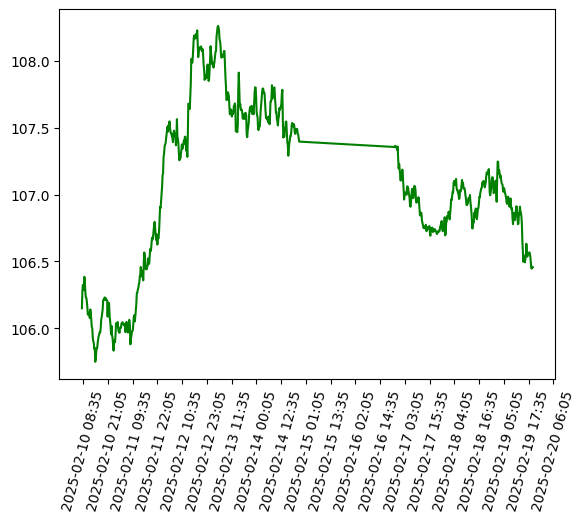

In [4]:
#plot the data over the past 3 days. This should be about 3*24*60/15 = 720*3 = 2160 candles

from matplotlib.category import StrCategoryConverter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

sub_df = df[-720:]#grab the last 720 candles

averages = sub_df["bid"].apply(lambda x: (float(x.get("l",None)) + float(x.get("h", None)))/2)

highs =sub_df["bid"].apply(lambda x: float(x.get("h", None)))
lows = sub_df["bid"].apply(lambda x: float(x.get("l", None)))
sub_df["time"] = pd.to_datetime(sub_df["time"])

fig, ax = plt.subplots()

ax.plot(sub_df["time"], averages, color='green', label='Average')
ax.tick_params(axis='x', rotation=75)
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=15*50))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))


plt.show()



Now to make some indicators on the dataset

First, I will calculate simple moving averages based on the price data.

SMA = (P1 + P2 + P3 + ... + Pn)/n
where n is the number of days over which I am taking the average.

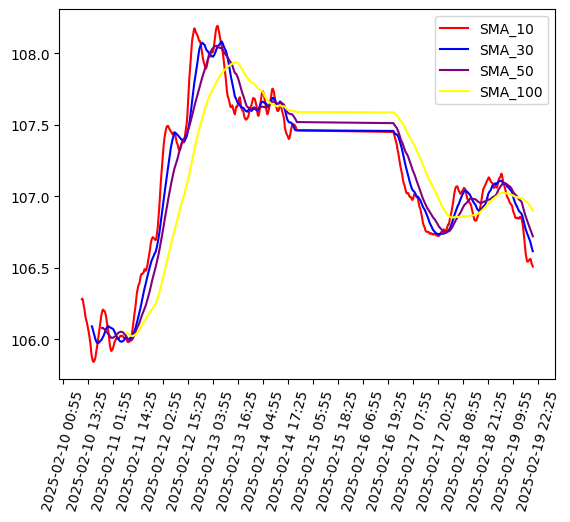

In [5]:
def getSMA(period, data: pd.DataFrame|pd.Series):
    if(type(data) == pd.DataFrame):
        return data["bid"].apply(lambda x: (float(x.get("l",None)) + float(x.get("h", None)))/2).rolling(period).mean()
    else:
        return data.rolling(period).mean()
    
fig, ax = plt.subplots()

ax.plot(sub_df["time"], getSMA(10, sub_df), color='red', label='SMA_10')
ax.plot(sub_df["time"], getSMA(30, sub_df), color='blue', label='SMA_30')
ax.plot(sub_df["time"], getSMA(50, sub_df), color='purple', label='SMA_50')
ax.plot(sub_df["time"], getSMA(100, sub_df), color='yellow', label='SMA_100')
ax.tick_params(axis='x', rotation=75)
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=15*50))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.legend()
plt.show()

Now I will calculate exponential moving average, which can then be used to calculate MACD.

80828    106.148000
80829    106.171182
80830    106.198785
80831    106.217097
80832    106.229716
            ...    
81543    106.550632
81544    106.531790
81545    106.516101
81546    106.505810
81547    106.456000
Name: bid, Length: 720, dtype: float64


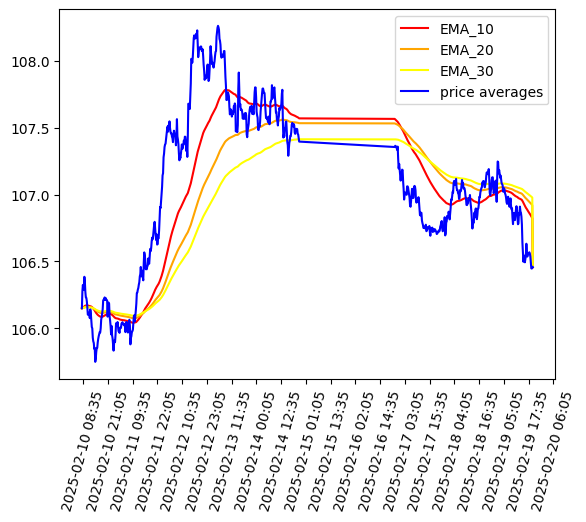

In [6]:
def getEMA(smoothing_factor, period, data: pd.DataFrame|pd.Series):
   if(type(data) == pd.DataFrame):
      price_avgs = data["bid"].apply(lambda x: (float(x.get("l",None)) + float(x.get("h", None)))/2)
   else:
      price_avgs = data
      
   ema = price_avgs.values[0]   
   for i in range(1, len(price_avgs)-1):
      #for j in range(0, period):
         #ema = price_avgs.values[i+j] * smoothing_factor/(period+1) + price_avgs.values[i+j-1]*(1-smoothing_factor/(period+1))
         ema = price_avgs.values[i]*smoothing_factor/(period+1) + ema*(1-smoothing_factor/(period+1))
         #price_avgs.values[i+j] = ema
         price_avgs.values[i] = ema

   return price_avgs


fig, ax = plt.subplots()
print(getEMA(2, 10, sub_df))

ax.plot(sub_df["time"], getEMA(0.2, 10, sub_df), color='red', label='EMA_10')
ax.plot(sub_df["time"], getEMA(0.2, 20, sub_df), color='orange', label='EMA_20')
ax.plot(sub_df["time"], getEMA(0.2, 30, sub_df), color='yellow', label='EMA_30')
ax.plot(sub_df["time"], averages, color='blue', label='price averages')

ax.tick_params(axis='x', rotation=75)
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=15*50))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.legend()
plt.show()

Now EMA can be used to calculate MACD

## This is a bad approach (but might still work)

MACD may need the data to go through denoising. Additionally, due to forex prices moving by tiny amounts, I need to rescale MACD by a small value so that the Signal line is different from MACD itself.

80828    0.000000
80829    0.000997
80830    0.002322
80831    0.003406
80832    0.004341
           ...   
81543   -0.031297
81544   -0.033174
81545   -0.034956
81546   -0.036526
81547    0.000000
Name: bid, Length: 720, dtype: float64
80828    0.000000
80829    0.001017
80830    0.002390
80831    0.003544
80832    0.004568
           ...   
81543   -0.105320
81544   -0.107876
81545   -0.110374
81546   -0.112691
81547    0.000000
Name: bid, Length: 720, dtype: float64


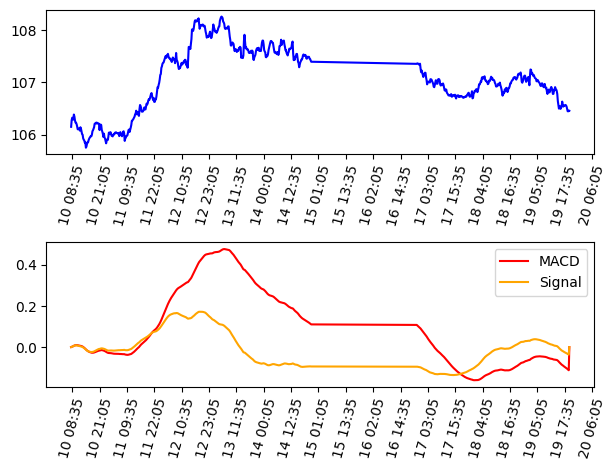

In [7]:
def getMACD(fast_period, slow_period, data: pd.DataFrame):
    fast_ema = getEMA(0.2, fast_period, data)
    slow_ema = getEMA(0.2, slow_period, data)
    macd = (fast_ema - slow_ema)
    signal = getEMA(0.2, 9, macd*1.001)#macd gets scaled up a bit to notice differences between macd and signal
    return macd, macd-signal

fig,ax = plt.subplots(2,1)
ax[0].plot(sub_df["time"], averages, color='blue', label='price averages')

macd,signal = getMACD(12, 26, sub_df)
print(signal)
print(macd)

ax[1].plot(sub_df["time"], macd, color='red', label='MACD')
ax[1].plot(sub_df["time"], signal, color='orange', label='Signal')




ax[0].tick_params(axis='x', rotation=75)
ax[1].tick_params(axis='x', rotation=75)
ax[0].xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=15*50))
ax[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %H:%M'))
ax[1].xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=15*50))
ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %H:%M'))

fig.tight_layout()
plt.legend()
plt.show()

Rate of change comes next.

This should generate a percentage change over time.
Increasing ROC period greatly smoothens out the graph, but very large period values might miss certain trends over time.

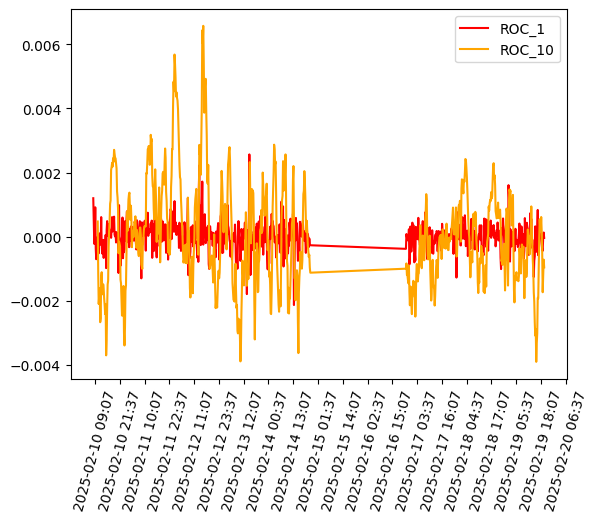

In [14]:
def getROC(period, data: pd.DataFrame):
    averages = data["bid"].apply(lambda x: (float(x.get("l",None)) + float(x.get("h", None)))/2)
    return averages.pct_change(period)#nice turns out pandas has a pct_change method

fig, ax = plt.subplots()

ax.plot(sub_df["time"], getROC(1, sub_df), color='red', label='ROC_1')
ax.plot(sub_df["time"], getROC(10, sub_df), color='orange', label='ROC_10')

ax.tick_params(axis='x', rotation=75)
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=15*50))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.legend()
plt.show()

Additionally, I think it would be a good idea to keep track of volume traded. This is only the volume that's been traded through Oanda, not global volume, but it might still be helpful.

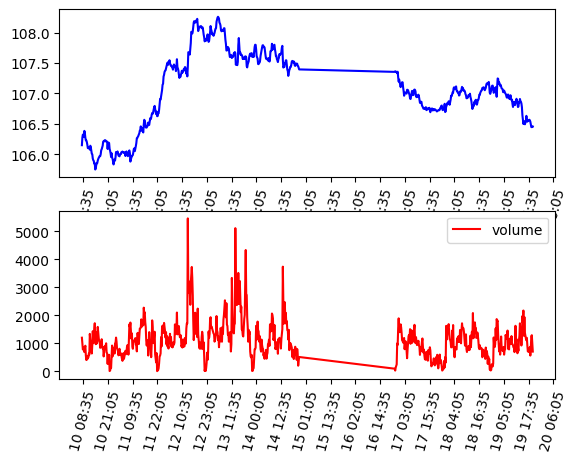

In [17]:
fix, ax = plt.subplots(2,1)

ax[0].plot(sub_df["time"], averages, color='blue', label='price')
ax[1].plot(sub_df["time"], sub_df["volume"], color='red', label='volume')

ax[0].tick_params(axis='x', rotation=75)
ax[1].tick_params(axis='x', rotation=75)

for a in ax:
    a.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=15*50))
    a.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %H:%M'))

fig.tight_layout()
plt.legend()
plt.show()

It seems to me that all the typical volatility indicators are not technical enough, and kind of reprocess what has been calculated in other indicators. Instead, I wish to use simple rolling standard deviation.

This is just standard deviation averaged over some window period.

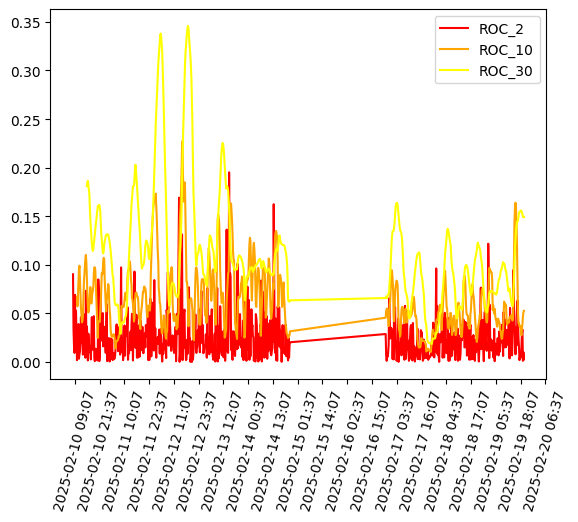

In [22]:
def getRstd(period, data: pd.DataFrame):
    averages = data["bid"].apply(lambda x: (float(x.get("l",None)) + float(x.get("h", None)))/2)
    return averages.rolling(period).std()

fig, ax = plt.subplots()

ax.plot(sub_df["time"], getRstd(2, sub_df), color='red', label='ROC_2')
ax.plot(sub_df["time"], getRstd(10, sub_df), color='orange', label='ROC_10')
ax.plot(sub_df["time"], getRstd(30, sub_df), color='yellow', label='ROC_30')

ax.tick_params(axis='x', rotation=75)
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=15*50))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.legend()
plt.show()

Since I have the resources to just train a model with these time series, I think I would rather do that instead of trying to see how all of these interact with each other.